In [1]:
import string
import pandas as pd
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from statistics import mean
from rouge_score import rouge_scorer

In [13]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')
scores

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765),
 'rouge2': Score(precision=0.2857142857142857, recall=0.25, fmeasure=0.26666666666666666),
 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}

In [2]:
# TODO: clean string
def clean_str(ans):
    return ans.translate(str.maketrans('', '', string.punctuation)).lower()

In [3]:
# sample testing
ans = clean_str('Hi! How are yo?')
ans

'hi how are yo'

In [4]:
ans_df = pd.read_csv('answer_nucleus_flan_t5_large_0.95_1.20_bluert.csv')

In [18]:
# Compute ROUGE Scores
r1, r2, rl = [], [], []
for i, row in ans_df.iterrows():
    # NOTE: Compute ROUGE Scores
    scores = scorer.score(clean_str(row['answer']), clean_str(row['generated_answer']))
    r1.append(scores['rouge1'][2]) # rouge-1 f1 score
    r2.append(scores['rouge2'][2]) # rouge-2 f1 score
    rl.append(scores['rougeL'][2]) # rouge-L f1 score

# Save ROUGE Scores
ans_df['Rouge 1'] = r1
ans_df['Rouge 2'] = r2
ans_df['Rouge L'] = rl
ans_df.to_csv('answer_nucleus_flan_t5_large_0.95_1.20_bluert_rouge.csv')

In [19]:
# Choose based on ROUGE scores
grp_pair_ids = ans_df.groupby('pair_id')
select_quests = defaultdict(list)
for pair_id, grp_content in grp_pair_ids:
    for i, row in grp_content.iterrows():
        if row['Rouge 1'] > 0.4:
            select_quests[pair_id].append(row['generated_question'])            

In [20]:
select_quests

defaultdict(list,
            {'0009e97f6d8c59da': ['Where did Jack my Hedgehog ride off to?',
              'Where did Jack the Hedgehog go with the cock?',
              'Where did Jack my Hedgehog ride to?',
              'Where did Jack my Hedgehog ride off?',
              'Where did Jack my Hedgehog ride off to?',
              'Where did Jack leave?',
              'Where did Jack my Hedgehog leave with all the pigs and asses he had promised to look after?',
              'Where did Jack my Hedgehog ride to before going back home?',
              'Where did Jack go after his father had the cock shod and his pigs and donkeys looked after?',
              'Where did Jack my Hedgehog arrive at when his father told him to do so?',
              'Where did Jack the Hedgehog ride off to?',
              'Where did Jack go?',
              'Where did Jack my Hedgehog go after the cock was shod?',
              'Where did Jack my Hedgehog ride to?',
              'Where did Jack ride to

In [22]:
# Correlation between ROUGE 1 and BLEURT Scores
corr = ans_df['bleurt_score'].corr(ans_df['Rouge 1'])
corr # Positive corelation

0.937084689563699

In [5]:
# NOTE: Exact match
grp_pair_ids = ans_df.groupby('pair_id')
valid_quests = defaultdict(list)
attrs, ls, ei = [], [], []
all_attrs, all_ls, all_ei = [], [], []
em_bleurt = []
for grp_full in grp_pair_ids:
    grp = grp_full[1]
    # store main information
    all_attrs.append(grp['attribute1'].tolist()[0])
    all_ls.append(grp['local_or_sum'].tolist()[0])
    all_ei.append(grp['ex_or_im'].tolist()[0])
    flag = True
    for i, row in grp.iterrows():
        # NOTE: check for exact match
        if clean_str(row['answer']) == clean_str(row['generated_answer']):
            valid_quests[row['pair_id']].append(row['generated_question'])
            if flag:
                em_bleurt.append(row['bleurt_score'])
                attrs.append(row['attribute1'])
                ls.append(row['local_or_sum'])
                ei.append(row['ex_or_im'])
                flag = False

0000d3d529705d1e
0009e97f6d8c59da
000c8e5e69475c8e
001aa3dd6bf5556c
001b747ece8a588a
001c915566f55dde
0056a3ab22af5ec4
005997b6fbed5993
005fd986e1525d16
00607d651b5b58d3
0064621e04ed5b3d
007e8d4db2255730
007fb65e0b225384
008209924db85713
0095984a05c956bd
0095e9356aa75644
00b0614538b05c5c
00b47bed35655e17
00c079c680fa5f7a
00c0aa1a278651e7
00ced3946feb590d
00d26192a6fb5b25
00d5dc6b253156c4
00d804539f5253db
00ef7e3a36225462
01085d47d2875155
011051965e3a5f38
01170d4462625485
011a5fe7b94d58c9
0120332e6e345434
0127fd196c5151fc
0135e7ed8b815bca
013e6f21788950ca
0140df712a6e55eb
0148f51455a55e97
014df05af53f5663
01522a4e0c365d27
01586aa2228f52a7
015c656308935d88
017168fd4fa056f4
0193057c88d35a33
0199449927855fa4
019edc5a4a8a5d6d
019f71b3d1755553
01a4d3f5c1aa5a3a
01c979e78a9e52ea
01caacbdbfea52cb
01cfb52067aa5158
01dec461babb59f8
01e33ce8adb25e3a
01e8489afc465889
0203b3c4c4e75a9b
0210099fb5735602
0211bce408b95be1
0219dcfd0dd251d6
02360737203d593b
023a0080b5fe5e09
023b45ec6b525e20
024bfa75016c51

542e72b6332351b8
5433918dbe6854b9
543616dc68b155c1
543d76554bf55555
54529534810d5d8e
545fda1a82b353c9
5467529fa53d5fb7
54687a92097d5613
5469b6e43bb85259
5484876ad9735bac
548681622ef45326
5492770af6815855
54956a2d802a550e
549762289cda5f88
549f8c8020745a1f
54a5b0217de355dc
54a72696099b56d8
54b905102a075e5a
54d46de796345db6
54e1360fd0405e1d
54ebdf552707556a
5516202040c953bb
55404e101fed56ff
55432564f87c5fca
5563759d83955f89
5563e52e7b005d5b
556400ba85955a35
55677ec3ecd4575d
5567f19c1f07528e
5580cf7579e75f6a
558a634f7f1c5a37
55adac0c8f185733
55af2977404a58a6
55c9b8e05a315688
55d6a51ad6b85c00
55ef9812bd7f543d
55f25b36c33254ac
55f65e45579b537d
55fb9d3d59d6531c
56027b467d2b501d
560a21cbf9a457b6
561ae42b38765abb
5621964319f45f6d
562727c74f6b5526
562b8c2b7378590d
56433d91300c5a11
5643ac043a495c40
564b01b612e35f1c
565399c7ae525a0c
566904affa435dd4
5669a27357a6516c
5674f7be9fbe5f71
568065bfcd315568
5683c0555fe55229
569f9e0cb8bd5209
56af942d80435c69
56d2acbfa981593a
56df703086785a1c
56eaf610d80859

In [18]:
valid_quests

defaultdict(list,
            {'0009e97f6d8c59da': ['Where did Jack my Hedgehog ride off to?',
              'Where did Jack the Hedgehog go with the cock?',
              'Where did Jack my Hedgehog ride to?',
              'Where did Jack my Hedgehog ride off?',
              'Where did Jack my Hedgehog ride off to?',
              'Where did Jack leave?',
              'Where did Jack my Hedgehog leave with all the pigs and asses he had promised to look after?',
              'Where did Jack my Hedgehog ride to before going back home?',
              'Where did Jack go after his father had the cock shod and his pigs and donkeys looked after?',
              'Where did Jack my Hedgehog arrive at when his father told him to do so?',
              'Where did Jack the Hedgehog ride off to?',
              'Where did Jack go?',
              'Where did Jack my Hedgehog go after the cock was shod?',
              'Where did Jack my Hedgehog ride to?',
              'Where did Jack ride to

In [28]:
# TODO: Append exact match questions with the train data
train_df = pd.read_csv('../Participant Data/train.csv')
idwise_train_info = {}
for i in range(len(train_df)):
    row_vals = train_df.loc[i].values
    idwise_train_info[row_vals[0]] = row_vals.tolist()
append_data = []
for pairid, aug_quests in valid_quests.items():
    for quest in aug_quests:
        orig_row = idwise_train_info[pairid]
        append_row = []
        for i, item in enumerate(orig_row):
            if i == 4:
                append_row.append(quest)
            else:
                append_row.append(item)
        append_data.append(append_row)
# Append to the train df
aug_train_df = train_df.append(pd.DataFrame(append_data,
                            columns=train_df.columns),
                            ignore_index=True)
aug_train_df.to_csv('Exact_Match_Augment_Train.csv', index=False)

/var/folders/6q/gxv2z40x4jj37_ksv541z0m40000gn/T/ipykernel_53975/113742378.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_train_df = train_df.append(pd.DataFrame(append_data,


In [27]:
len(train_df)

6989

In [26]:
len(aug_train_df)

87163

In [6]:
valid_quests

defaultdict(list,
            {'0009e97f6d8c59da': ['Where did Jack my Hedgehog ride off to?',
              'Where did Jack the Hedgehog go with the cock?',
              'Where did Jack my Hedgehog ride to?',
              'Where did Jack my Hedgehog ride off?',
              'Where did Jack my Hedgehog ride off to?',
              'Where did Jack leave?',
              'Where did Jack my Hedgehog leave with all the pigs and asses he had promised to look after?',
              'Where did Jack my Hedgehog ride to before going back home?',
              'Where did Jack go after his father had the cock shod and his pigs and donkeys looked after?',
              'Where did Jack my Hedgehog arrive at when his father told him to do so?',
              'Where did Jack the Hedgehog ride off to?',
              'Where did Jack go?',
              'Where did Jack my Hedgehog go after the cock was shod?',
              'Where did Jack my Hedgehog ride to?',
              'Where did Jack ride to

In [7]:
print('Total samples:', len(set(ans_df['pair_id'].tolist())))

Total samples: 6005


In [8]:
valid_pair_ids = list(valid_quests.keys())

In [10]:
def get_stats_of_matching(valid_quests, attrs, ls, ei, all_attrs, all_ls, all_ei):
    print('Samples with atleast one match:', len(valid_quests))
    attr_stats = Counter(attrs)
    # print(attr_stats)
    ls_stats = Counter(ls)
    # print(ls_stats)
    ei_stats = Counter(ei)
    # print(ei_stats)
    all_attrs_stats = Counter(all_attrs)
    # print(all_attrs_stats)
    all_ls_stats = Counter(all_ls)
    # print(all_ls_stats)
    all_ei_stats = Counter(all_ei)
    # print(all_ei_stats)
    print('############################')
    print('Fraction matches by attribute type:')
    for attr, count in all_attrs_stats.items():
        em_count = attr_stats[attr]
        frac = em_count/count
        print('{:s} : {:.2f}'.format(attr, frac))
    print('############################')
    print('Fraction matches by locality:')
    for ls, count in all_ls_stats.items():
        em_count = ls_stats[ls]
        frac = em_count/count
        print('{:s} : {:.2f}'.format(ls, frac))
    print('############################')
    print('Fraction matches by explicit/implicit:')
    for ei, count in all_ei_stats.items():
        em_count = ei_stats[ei]
        frac = em_count/count
        print('{:s} : {:.2f}'.format(ei, frac))
    print('############################')

In [11]:
print('Stats for Exact Match')
print('############################')
get_stats_of_matching(valid_quests, attrs, ls, ei, all_attrs, all_ls, all_ei)

Stats for Exact Match
############################
Samples with atleast one match: 3378
############################
Fraction matches by attribute type:
prediction : 0.34
setting : 0.78
action : 0.64
causal relationship : 0.34
outcome resolution : 0.55
feeling : 0.62
character : 0.80
############################
Fraction matches by locality:
summary : 0.16
local : 0.60
############################
Fraction matches by explicit/implicit:
explicit : 0.69
implicit : 0.18
############################


In [22]:
print('BLEURT of Exact Matches:')
print('Minimum:', min(em_bleurt))
print('Maximum:', max(em_bleurt))
print('Mean:', mean(em_bleurt))

BLEURT of Exact Matches:
Minimum: 0.3079376220703125
Maximum: 1.0948092937469482
Mean: 0.9446384950704727


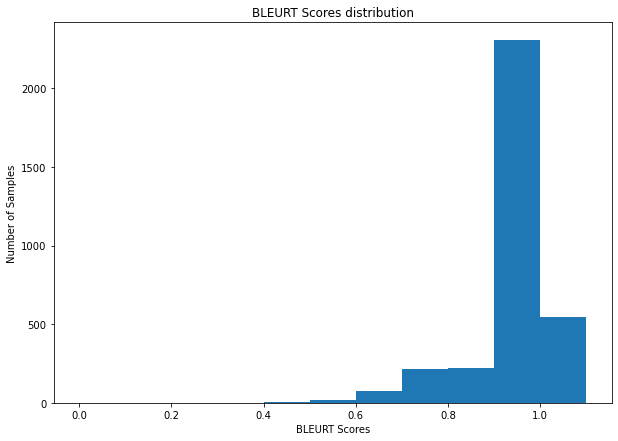

In [29]:
fig, ax = plt.subplots(figsize =(10, 7))
bins = [0.1*ctr for ctr in range(0, 12)]
ax.hist(em_bleurt, bins = bins)
plt.xlabel('BLEURT Scores')
plt.ylabel('Number of Samples')
plt.title('BLEURT Scores distribution')

 
# Show plot
plt.show()

In [44]:
# # NOTE: generated contained in ground-truth
# grp_pair_ids = ans_df.groupby('pair_id')
# valid_quests = defaultdict(list)
# attrs, ls, ei = [], [], []
# all_attrs, all_ls, all_ei = [], [], []
# for grp_full in grp_pair_ids:
#     grp = grp_full[1]
#     # store main information
#     all_attrs.append(grp['attribute1'].tolist()[0])
#     all_ls.append(grp['local_or_sum'].tolist()[0])
#     all_ei.append(grp['ex_or_im'].tolist()[0])
#     flag = True
#     for i, row in grp.iterrows():
#         if clean_str(row['answer']) in clean_str(row['generated_answer']):
#             valid_quests[row['pair_id']].append(row['generated_question'])
#             if flag:
#                 attrs.append(row['attribute1'])
#                 ls.append(row['local_or_sum'])
#                 ei.append(row['ex_or_im'])
#                 flag = False

In [45]:
# print('Stats for generated contained in ground-truth match')
# get_stats_of_matching(valid_quests, attrs, ls, ei, all_attrs, all_ls, all_ei)

Stats for generated contained in ground-truth match
Samples with atleast one match: 3637
############################
Fraction matches by attribute type:
prediction : 0.37
setting : 0.81
action : 0.70
causal relationship : 0.38
outcome resolution : 0.61
feeling : 0.65
character : 0.82
############################
Fraction matches by locality:
summary : 0.19
local : 0.64
############################
Fraction matches by explicit/implicit:
explicit : 0.74
implicit : 0.20
############################
